In [1]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
import itertools

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, BucketedRandomProjectionLSH
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

from utils import *

pio.renderers.default = "iframe"

In [2]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/03/16 17:19:42 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
24/03/16 17:19:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/16 17:19:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
base_path = "/data/saturation/thesis_run_20240130"
r_stat = 5
study_region_size = 2000 * 2000 / r_stat ** 2

configs_df = create_configs_df(read_configs(base_path, spark))
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")

# State c2c nn dist in terms of r_stat and log-scale
data = data.select(
    "*",
    F.log10(F.col("center_to_center_nearest_neighbor_distance_mean") / F.lit(r_stat)).alias("log_mean_c2c_nn_dist"),
    F.log10(F.col("n_craters_in_study_region")).alias("log_n_craters_in_study_region"),
    F.log10("n_craters_added_in_study_region").alias("log_n_craters_added_in_study_region"),
    (F.col("n_craters_in_study_region") / F.col("n_craters_added_in_study_region")).alias("information_remaining")
)

In [4]:
data.count()

444699515

In [5]:
data_subset = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(100))
).sample(0.0005)

df = join_configs(data_subset, configs_df, spark).toPandas()

In [6]:
configs_df.toPandas().sort_values("slope")

,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,simulation_id,slope
7003,1.467602,0.686809,10.148981,2164,1.000246
709,1.624211,0.604381,14.055626,1148,1.000381
1207,1.436503,0.392966,12.947683,5510,1.000389
7522,1.447905,0.740991,12.896511,1017,1.000441
689,1.583571,0.543519,6.508161,1142,1.000661
...,...,...,...,...,...
7443,1.369571,0.492816,13.385134,5501,2.999578
2243,1.877052,0.745182,13.677595,1925,2.999638
2081,1.655109,0.690670,6.200024,9648,2.999713
8468,1.783821,0.642164,9.567673,7919,2.999827


In [36]:
def dual_plot_for_simulation(simulation_id: int,
                             var1: str,
                             var1_label: str,
                             var2: str,
                             var2_label: str,
                             stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id].sort_values("n_craters_added_in_study_region")
    df.head()
    
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    fig = plt.figure(figsize=(8, 3))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df[var1], color='red', label=var1_label, lw=1, ls="-")
    ax1.set_ylabel(var1_label)
    ax1.set_xlabel("$N_{tot}$")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, df[var2], color="blue", label=var2_label, lw=1, ls="--")
    ax2.set_ylabel(var2_label)
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    ax1.set_title(f"Simulation {simulation_id}")

    plt.show()

slope                          2.221165
effective_radius_multiplier    1.423381
r_stat_multiplier              8.305324
min_rim_percentage             0.261066
Name: 12458, dtype: float64


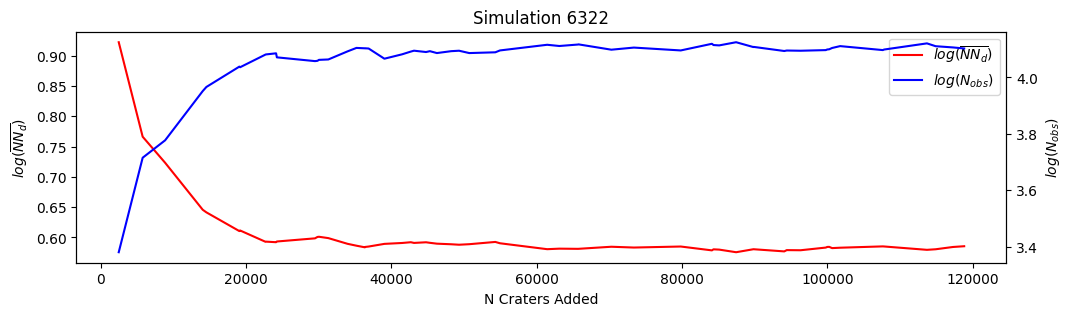

slope                           1.317733
effective_radius_multiplier     1.143681
r_stat_multiplier              12.276760
min_rim_percentage              0.590818
Name: 201431, dtype: float64


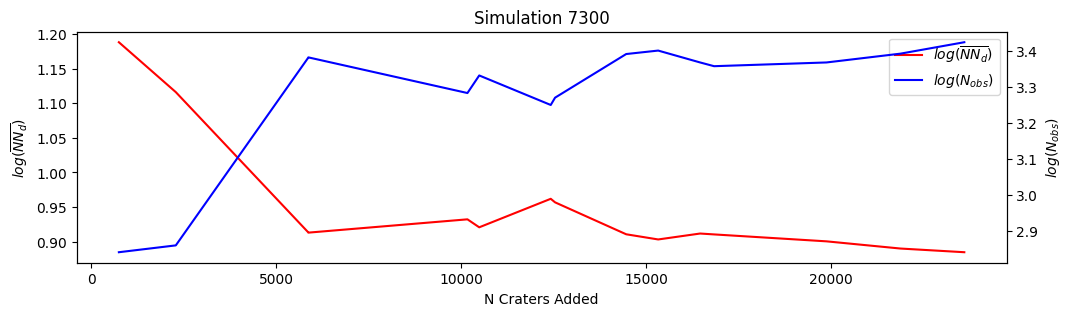

slope                          1.041831
effective_radius_multiplier    1.219036
r_stat_multiplier              9.502242
min_rim_percentage             0.388724
Name: 218876, dtype: float64


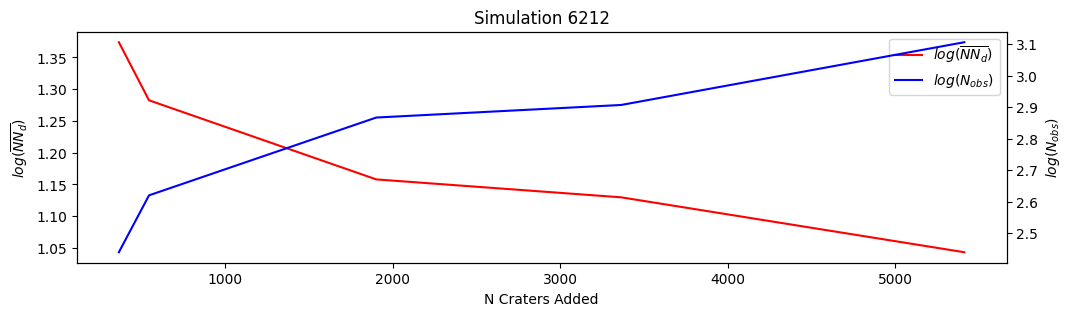

slope                           1.970031
effective_radius_multiplier     1.792092
r_stat_multiplier              13.725849
min_rim_percentage              0.411946
Name: 156932, dtype: float64


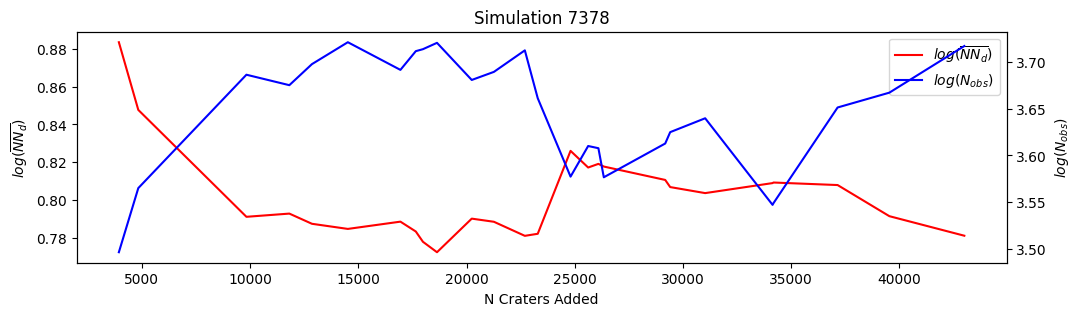

slope                           2.334250
effective_radius_multiplier     1.680126
r_stat_multiplier              12.597545
min_rim_percentage              0.480522
Name: 144424, dtype: float64


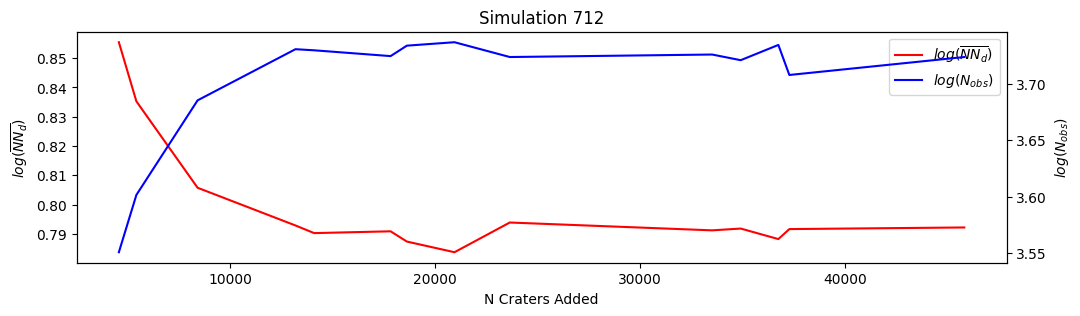

slope                           2.872264
effective_radius_multiplier     1.148510
r_stat_multiplier              11.448836
min_rim_percentage              0.598170
Name: 151407, dtype: float64


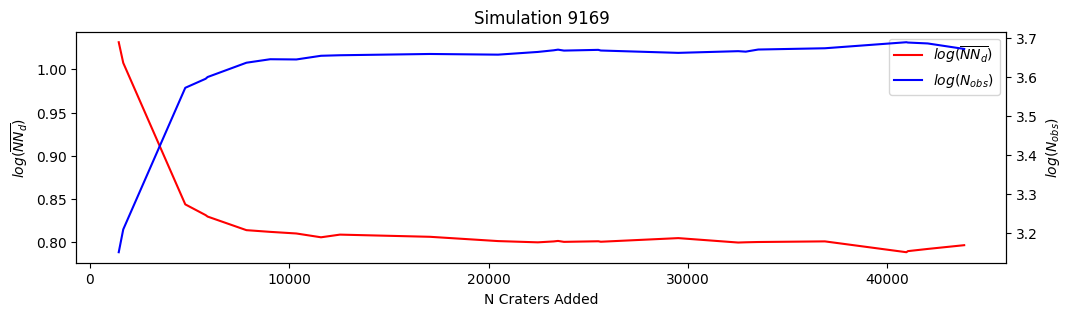

slope                          1.024029
effective_radius_multiplier    1.643011
r_stat_multiplier              9.819024
min_rim_percentage             0.488392
Name: 221862, dtype: float64


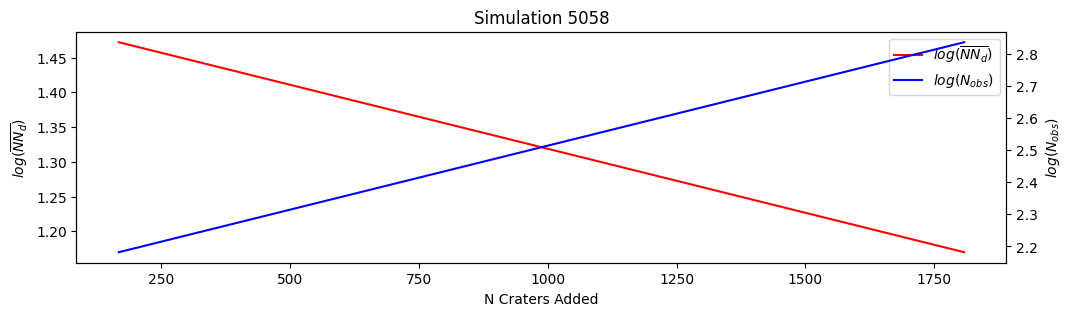

slope                          2.763229
effective_radius_multiplier    1.657631
r_stat_multiplier              9.887931
min_rim_percentage             0.409956
Name: 146219, dtype: float64


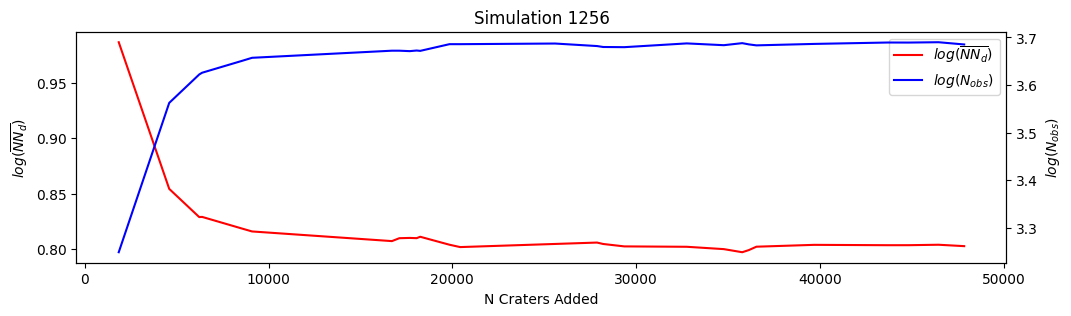

slope                           2.045198
effective_radius_multiplier     1.351467
r_stat_multiplier              14.962729
min_rim_percentage              0.405881
Name: 58637, dtype: float64


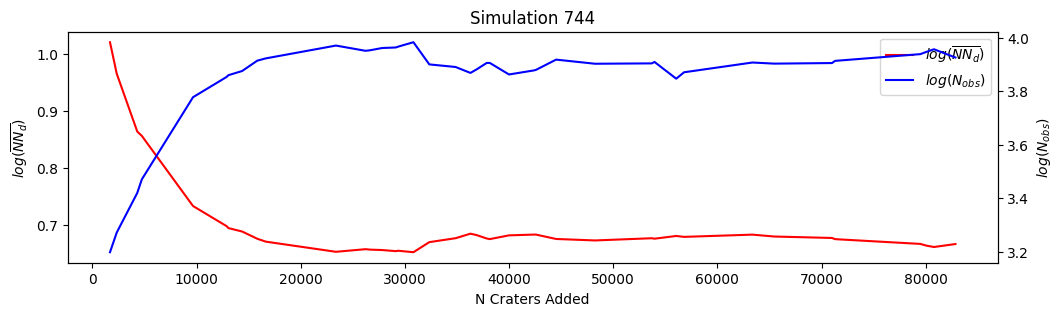

slope                           1.270826
effective_radius_multiplier     1.792723
r_stat_multiplier              10.124502
min_rim_percentage              0.349630
Name: 220135, dtype: float64


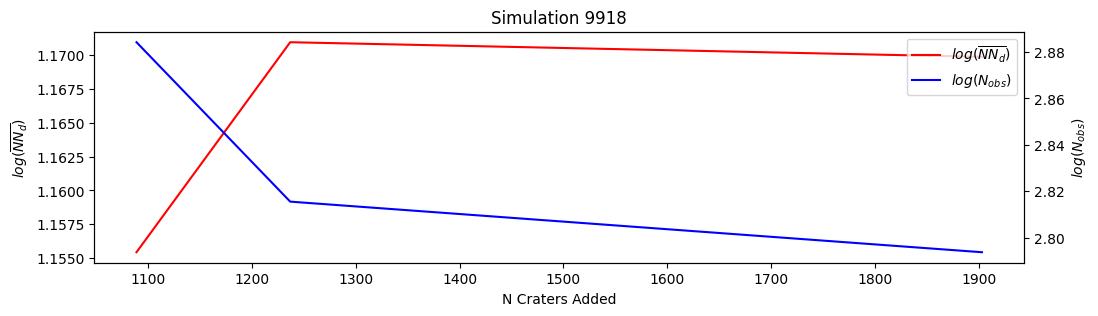

slope                          1.523269
effective_radius_multiplier    1.179174
r_stat_multiplier              7.111516
min_rim_percentage             0.303982
Name: 130129, dtype: float64


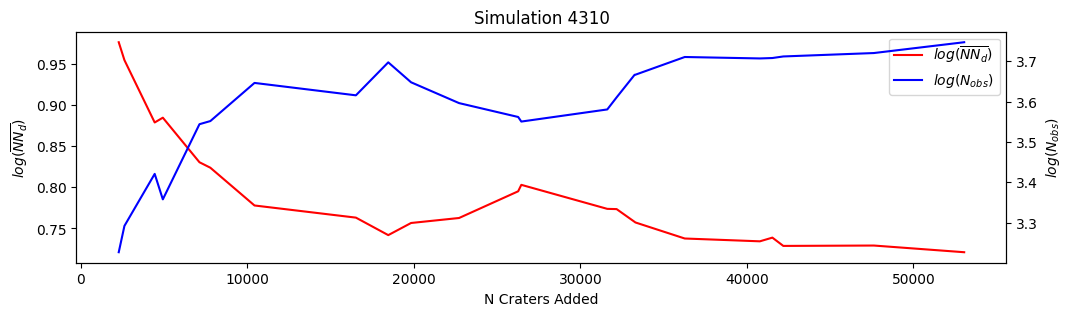

slope                           1.049683
effective_radius_multiplier     1.642449
r_stat_multiplier              14.488209
min_rim_percentage              0.510232
Name: 221874, dtype: float64


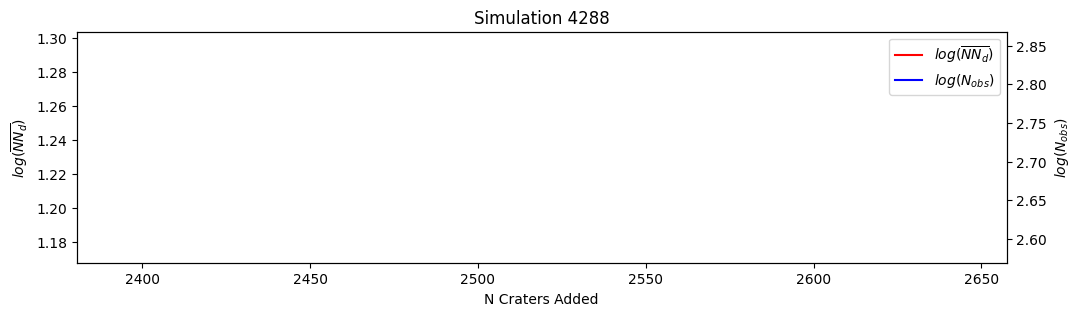

slope                          2.329721
effective_radius_multiplier    1.818210
r_stat_multiplier              7.849751
min_rim_percentage             0.491239
Name: 177237, dtype: float64


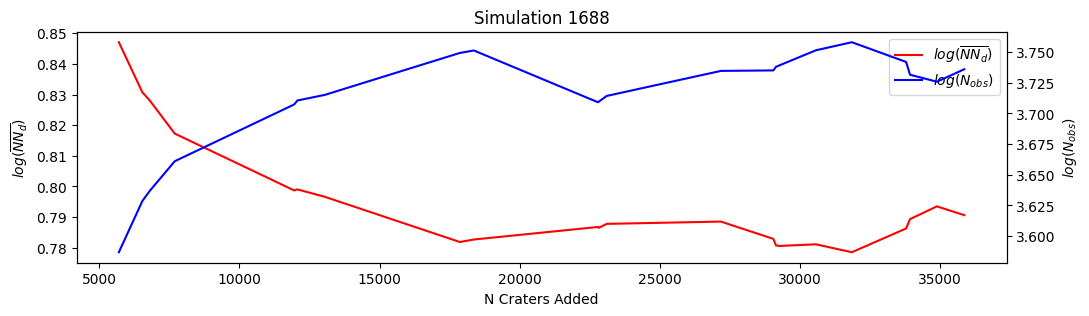

slope                           2.981342
effective_radius_multiplier     1.270277
r_stat_multiplier              14.317096
min_rim_percentage              0.537129
Name: 190255, dtype: float64


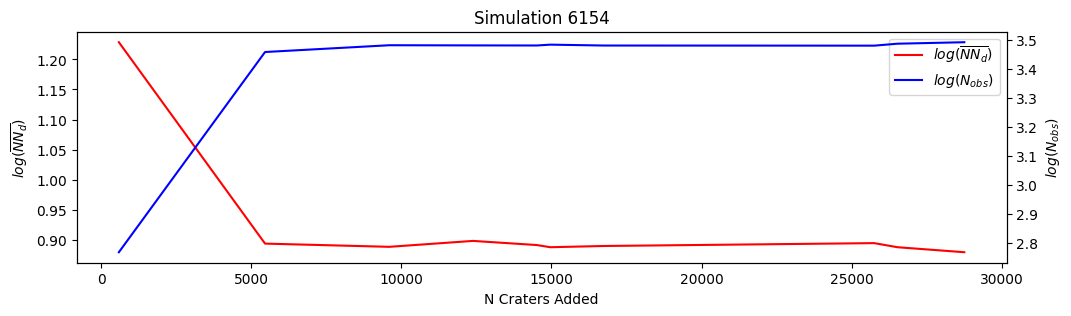

slope                           2.096350
effective_radius_multiplier     1.427829
r_stat_multiplier              11.629281
min_rim_percentage              0.339767
Name: 36790, dtype: float64


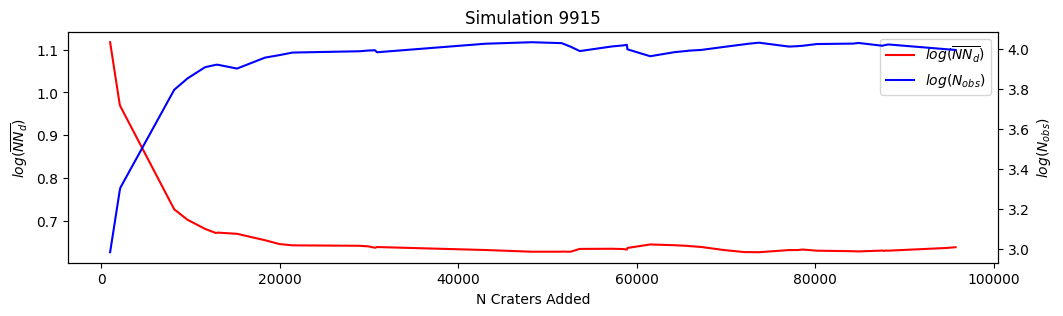

slope                           1.589516
effective_radius_multiplier     1.424061
r_stat_multiplier              12.422188
min_rim_percentage              0.250406
Name: 180664, dtype: float64


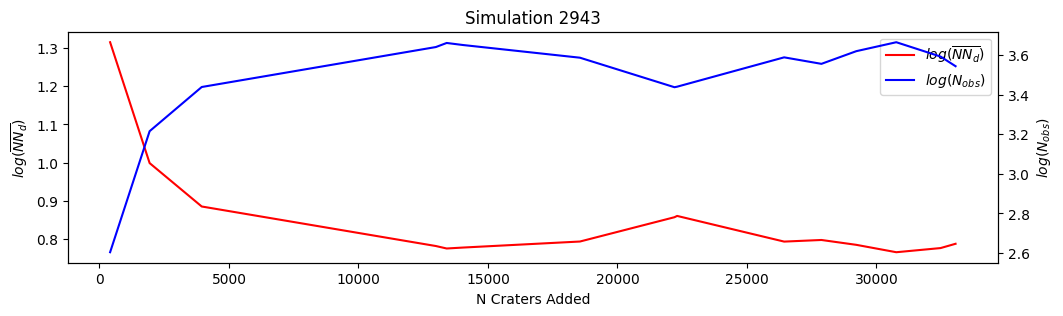

slope                          1.753481
effective_radius_multiplier    1.332015
r_stat_multiplier              9.114783
min_rim_percentage             0.586927
Name: 151661, dtype: float64


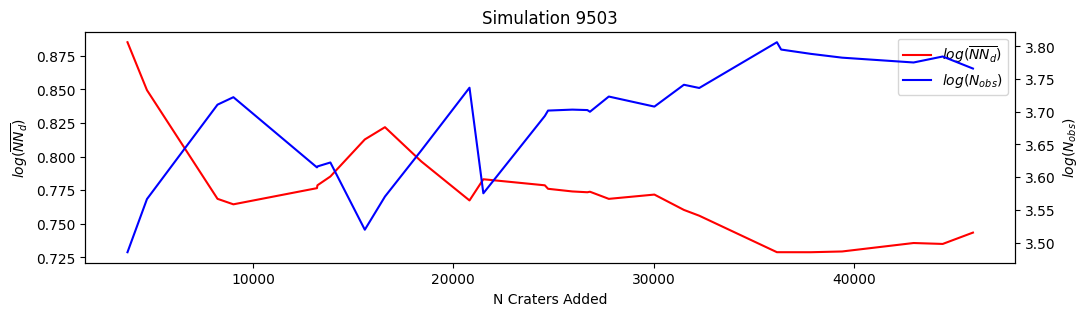

slope                           2.625291
effective_radius_multiplier     1.764840
r_stat_multiplier              14.769337
min_rim_percentage              0.629713
Name: 205187, dtype: float64


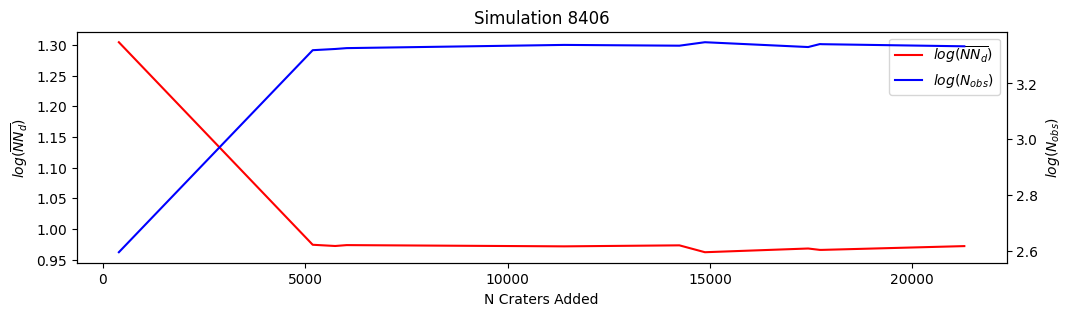

slope                           2.978161
effective_radius_multiplier     1.354741
r_stat_multiplier              11.996818
min_rim_percentage              0.406615
Name: 153840, dtype: float64


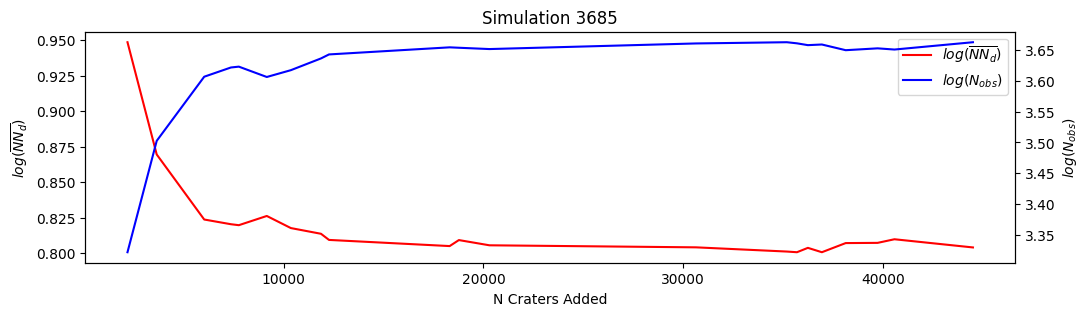

slope                           2.063415
effective_radius_multiplier     1.124920
r_stat_multiplier              13.802656
min_rim_percentage              0.344937
Name: 5751, dtype: float64


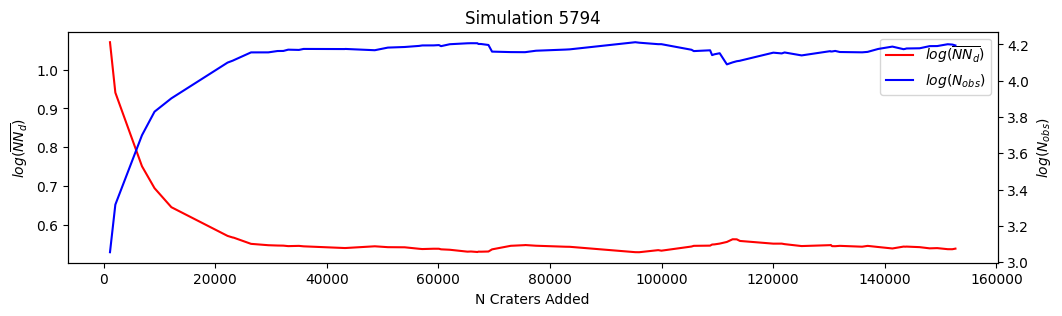

In [8]:
for sim_id in np.random.choice(df.simulation_id.drop_duplicates(), 20):
    # plot_log_N_and_log_NNd_for_simulation(sim_id, df)

In [ ]:
sim_ids = [5058, 8406, 4288]
ds = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(100))
    & (F.col("simulation_id").isin(sim_ids))
).sample(0.1)

df_s = join_configs(ds, configs_df, spark).toPandas()

slope                          1.024029
effective_radius_multiplier    1.643011
r_stat_multiplier              9.819024
min_rim_percentage             0.488392
Name: 2092, dtype: float64


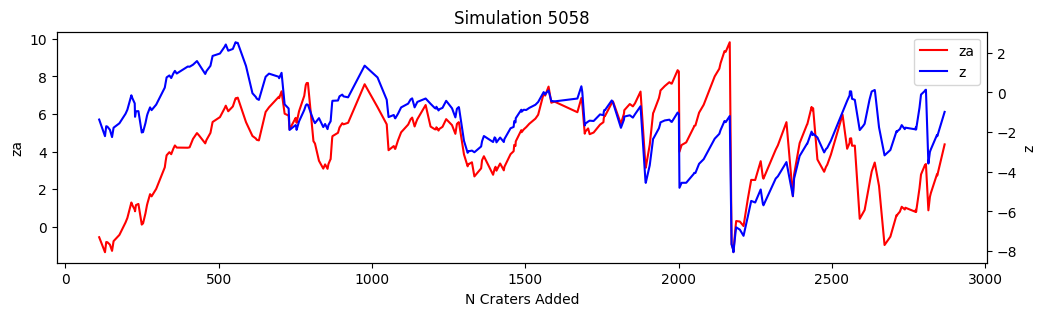

slope                          1.024029
effective_radius_multiplier    1.643011
r_stat_multiplier              9.819024
min_rim_percentage             0.488392
Name: 2092, dtype: float64


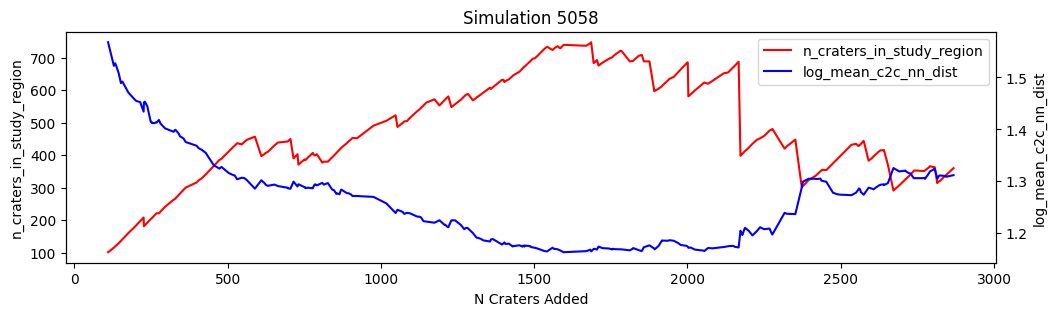

slope                           2.625291
effective_radius_multiplier     1.764840
r_stat_multiplier              14.769337
min_rim_percentage              0.629713
Name: 0, dtype: float64


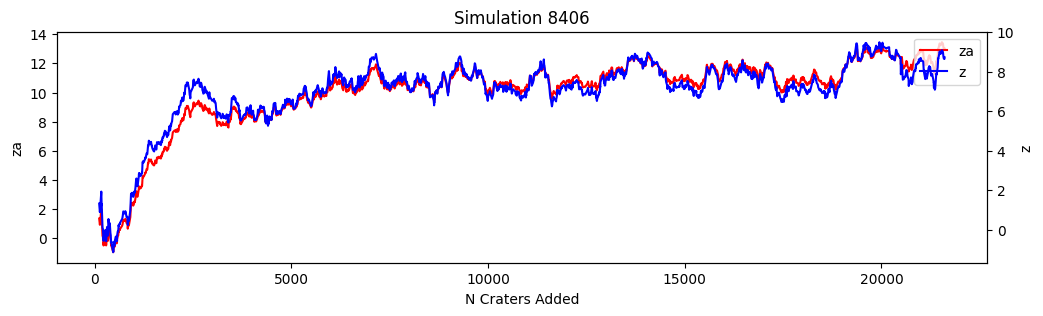

slope                           2.625291
effective_radius_multiplier     1.764840
r_stat_multiplier              14.769337
min_rim_percentage              0.629713
Name: 0, dtype: float64


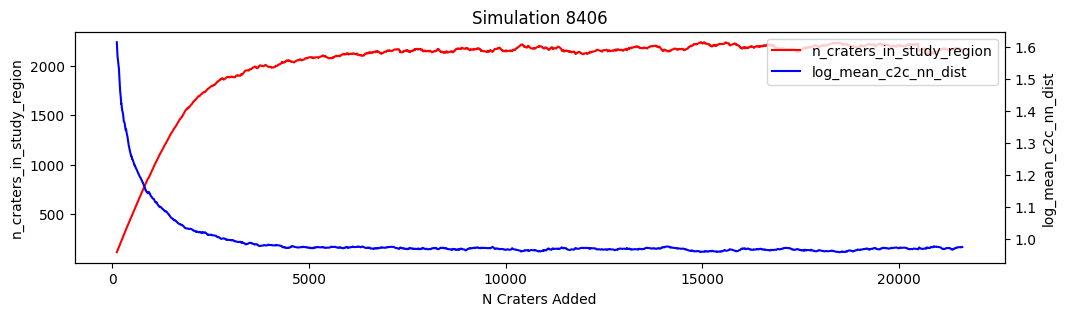

slope                           1.049683
effective_radius_multiplier     1.642449
r_stat_multiplier              14.488209
min_rim_percentage              0.510232
Name: 2367, dtype: float64


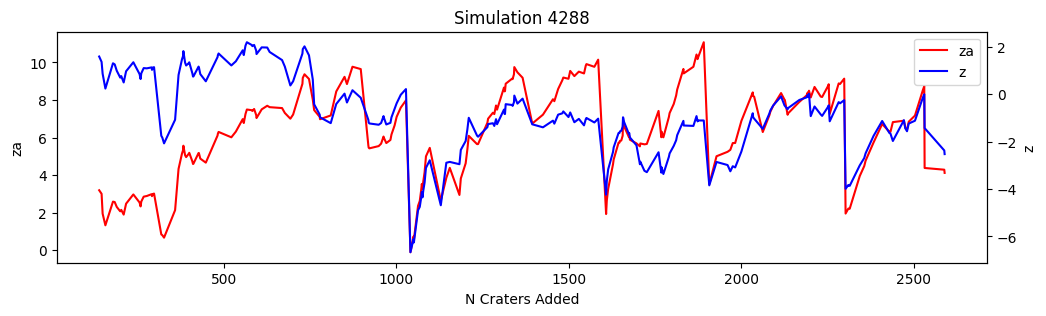

slope                           1.049683
effective_radius_multiplier     1.642449
r_stat_multiplier              14.488209
min_rim_percentage              0.510232
Name: 2367, dtype: float64


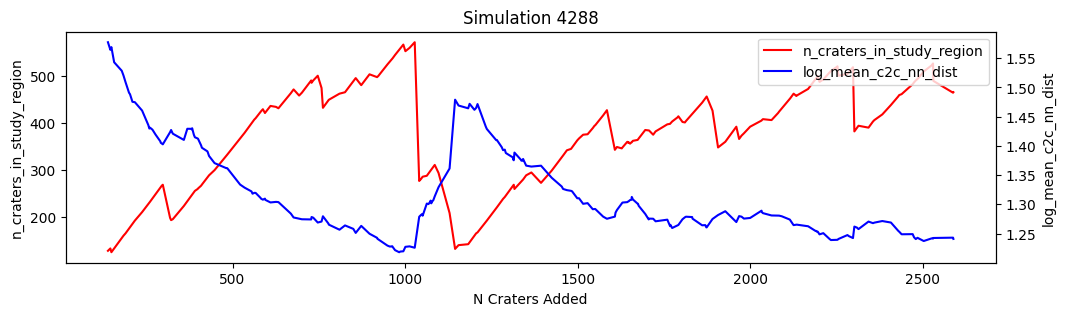

In [20]:
for sim_id in sim_ids:
    dual_plot_for_simulation(sim_id, "za", "z", df_s)
    dual_plot_for_simulation(sim_id, "n_craters_in_study_region", "log_mean_c2c_nn_dist", df_s)
    # plot_log_N_and_log_NNd_for_simulation(sim_id, df_s)
    # plot_AD_and_Za_for_simulation(sim_id, df_s)

In [23]:
sim_ids = list(np.random.choice(df.simulation_id.drop_duplicates(), 20))
ds = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(100))
    & (F.col("simulation_id").isin(sim_ids))
).sample(0.1)

df_s = join_configs(ds, configs_df, spark).toPandas()

slope                           2.547133
effective_radius_multiplier     1.516991
r_stat_multiplier              11.638927
min_rim_percentage              0.376099
Name: 33271, dtype: float64


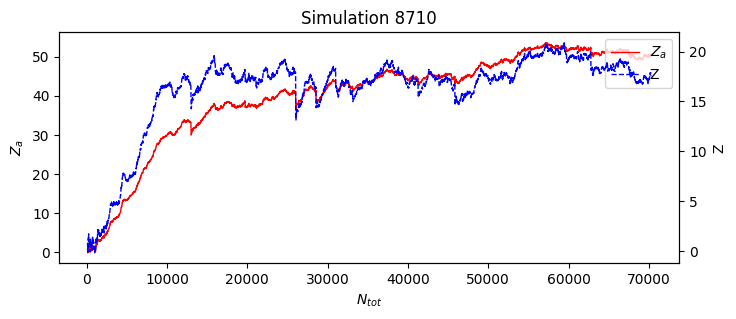

slope                           2.547133
effective_radius_multiplier     1.516991
r_stat_multiplier              11.638927
min_rim_percentage              0.376099
Name: 33271, dtype: float64


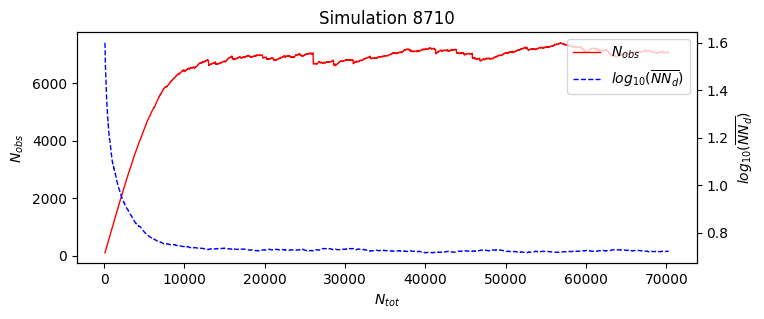

slope                           2.103173
effective_radius_multiplier     1.598975
r_stat_multiplier              10.397634
min_rim_percentage              0.278933
Name: 46925, dtype: float64


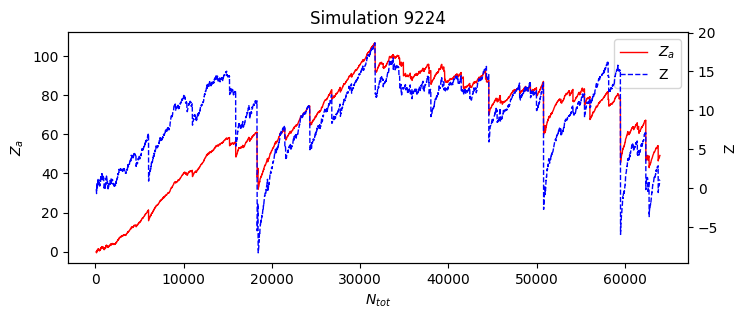

slope                           2.103173
effective_radius_multiplier     1.598975
r_stat_multiplier              10.397634
min_rim_percentage              0.278933
Name: 46925, dtype: float64


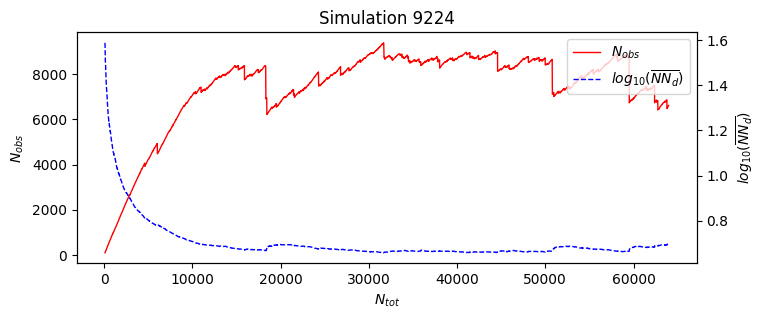

slope                           2.957091
effective_radius_multiplier     1.364518
r_stat_multiplier              12.624274
min_rim_percentage              0.743467
Name: 84970, dtype: float64


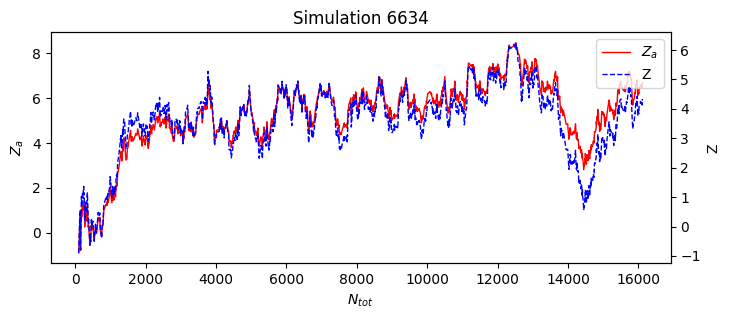

slope                           2.957091
effective_radius_multiplier     1.364518
r_stat_multiplier              12.624274
min_rim_percentage              0.743467
Name: 84970, dtype: float64


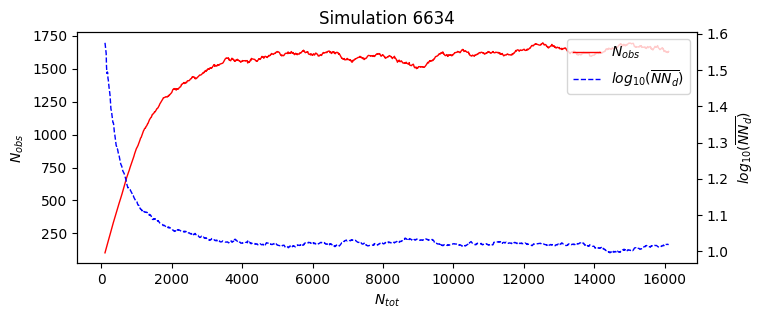

slope                           1.386621
effective_radius_multiplier     1.142775
r_stat_multiplier              12.597394
min_rim_percentage              0.421253
Name: 76547, dtype: float64


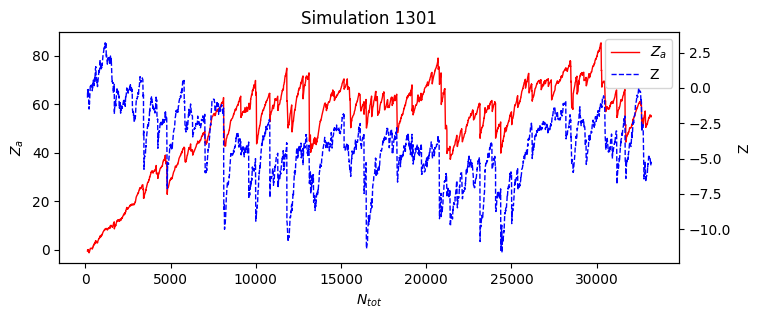

slope                           1.386621
effective_radius_multiplier     1.142775
r_stat_multiplier              12.597394
min_rim_percentage              0.421253
Name: 76547, dtype: float64


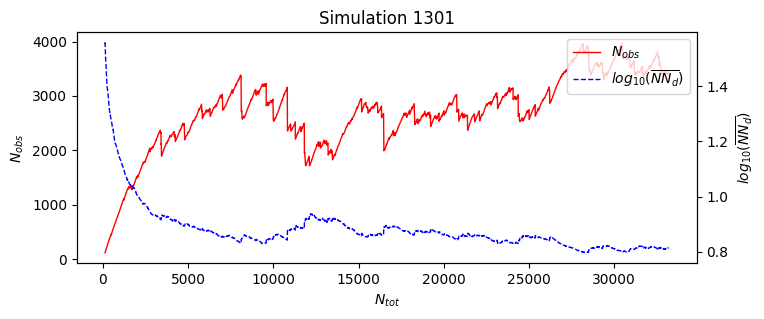

slope                           1.367489
effective_radius_multiplier     1.601029
r_stat_multiplier              11.565327
min_rim_percentage              0.560360
Name: 88963, dtype: float64


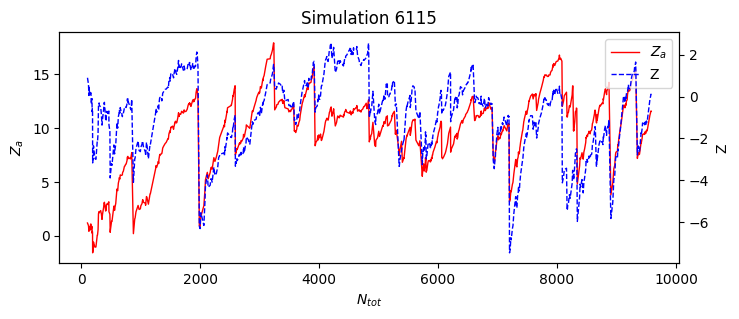

slope                           1.367489
effective_radius_multiplier     1.601029
r_stat_multiplier              11.565327
min_rim_percentage              0.560360
Name: 88963, dtype: float64


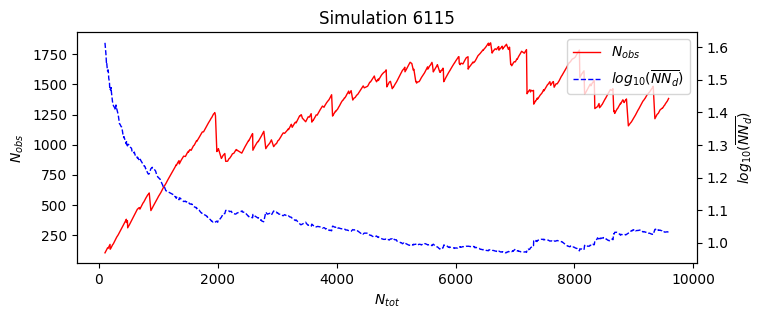

slope                          1.970806
effective_radius_multiplier    1.596298
r_stat_multiplier              8.199049
min_rim_percentage             0.319156
Name: 25922, dtype: float64


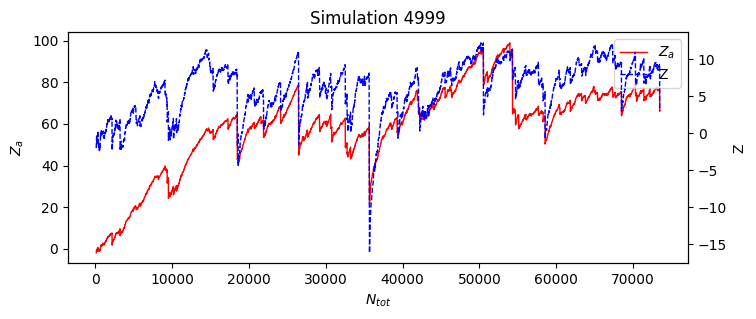

slope                          1.970806
effective_radius_multiplier    1.596298
r_stat_multiplier              8.199049
min_rim_percentage             0.319156
Name: 25922, dtype: float64


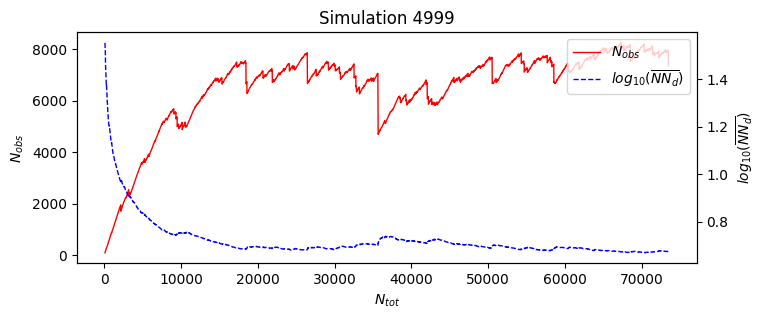

slope                           2.833844
effective_radius_multiplier     1.360492
r_stat_multiplier              10.118333
min_rim_percentage              0.620975
Name: 69386, dtype: float64


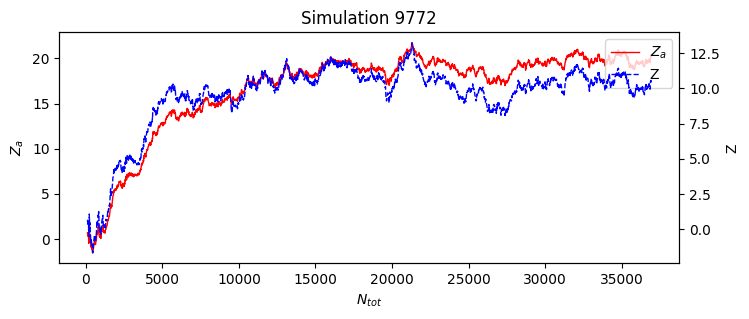

slope                           2.833844
effective_radius_multiplier     1.360492
r_stat_multiplier              10.118333
min_rim_percentage              0.620975
Name: 69386, dtype: float64


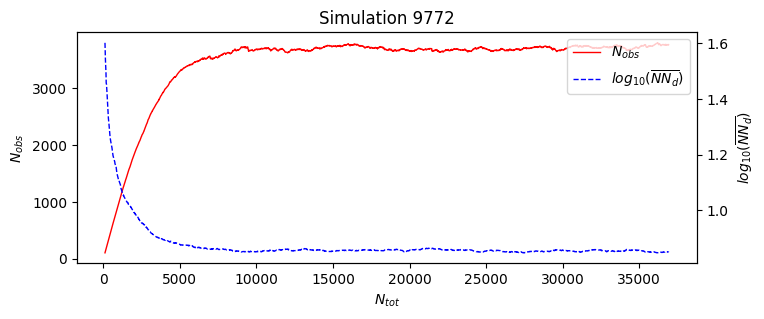

slope                           2.189336
effective_radius_multiplier     1.158993
r_stat_multiplier              14.538745
min_rim_percentage              0.691894
Name: 40365, dtype: float64


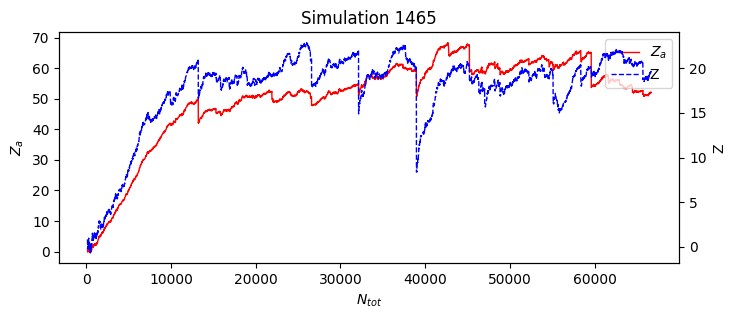

slope                           2.189336
effective_radius_multiplier     1.158993
r_stat_multiplier              14.538745
min_rim_percentage              0.691894
Name: 40365, dtype: float64


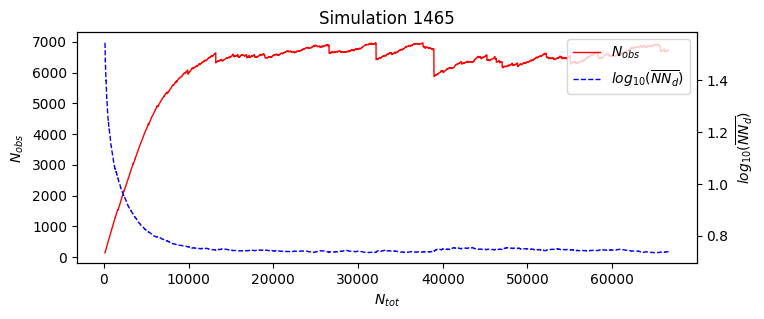

slope                           2.162389
effective_radius_multiplier     1.314036
r_stat_multiplier              14.509567
min_rim_percentage              0.366793
Name: 0, dtype: float64


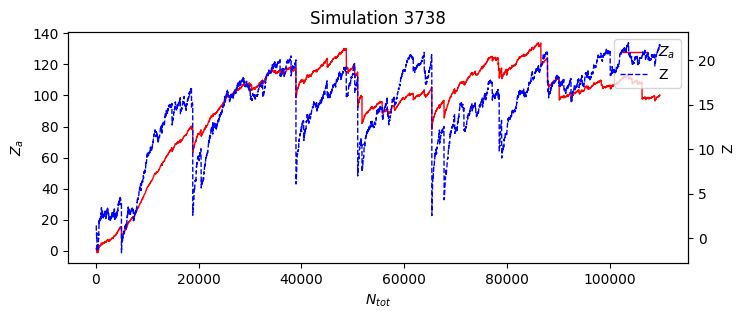

slope                           2.162389
effective_radius_multiplier     1.314036
r_stat_multiplier              14.509567
min_rim_percentage              0.366793
Name: 0, dtype: float64


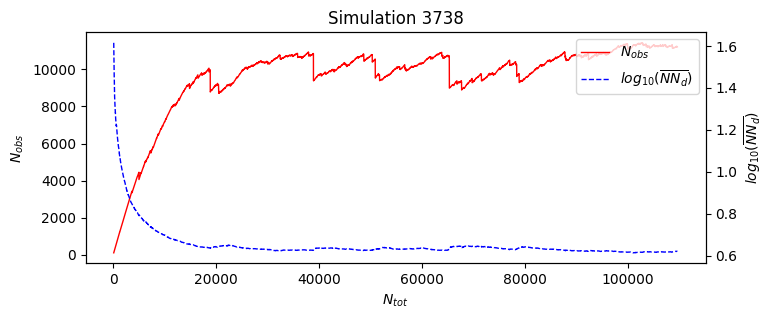

slope                           2.768051
effective_radius_multiplier     1.578064
r_stat_multiplier              11.544490
min_rim_percentage              0.383771
Name: 64465, dtype: float64


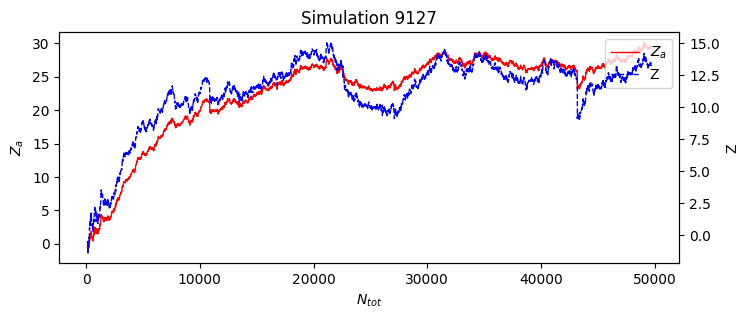

slope                           2.768051
effective_radius_multiplier     1.578064
r_stat_multiplier              11.544490
min_rim_percentage              0.383771
Name: 64465, dtype: float64


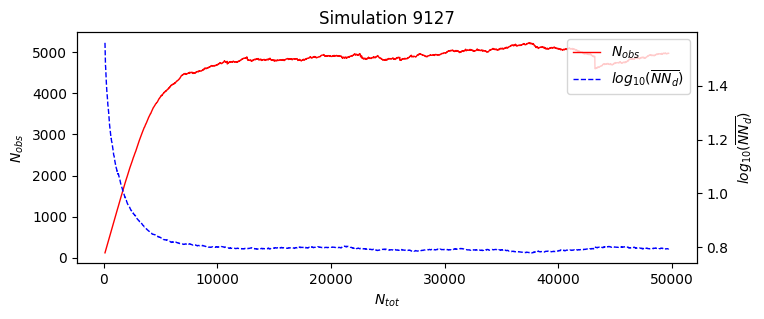

slope                          1.413496
effective_radius_multiplier    1.623792
r_stat_multiplier              7.657887
min_rim_percentage             0.703091
Name: 89911, dtype: float64


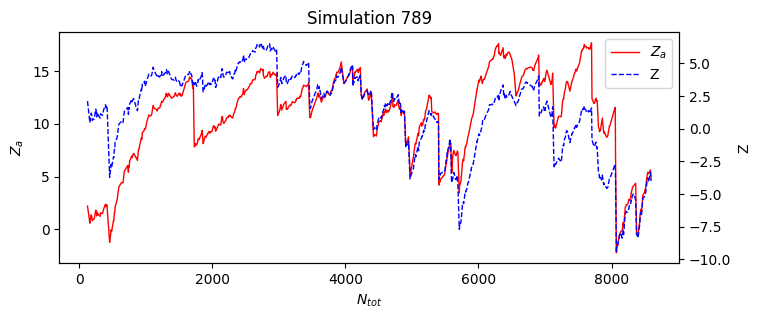

slope                          1.413496
effective_radius_multiplier    1.623792
r_stat_multiplier              7.657887
min_rim_percentage             0.703091
Name: 89911, dtype: float64


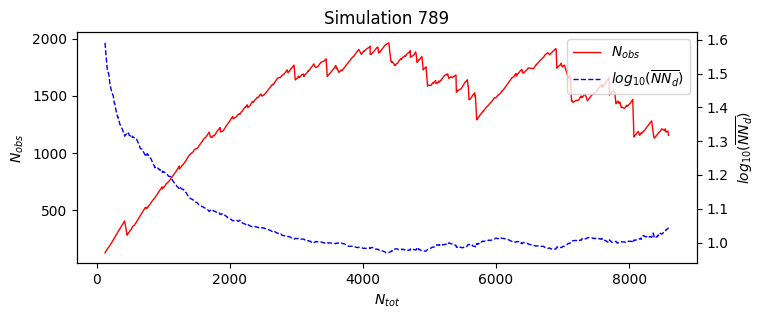

slope                           1.008136
effective_radius_multiplier     1.463174
r_stat_multiplier              10.064938
min_rim_percentage              0.384781
Name: 90760, dtype: float64


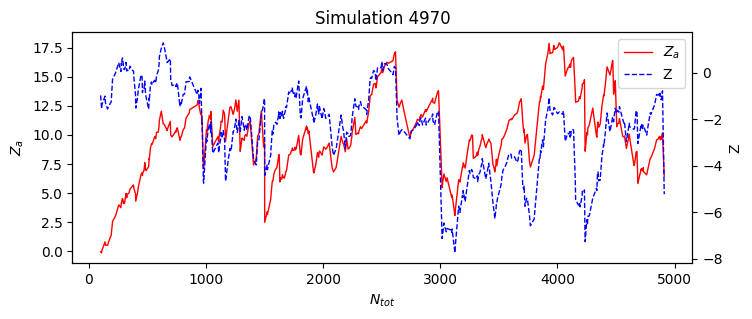

slope                           1.008136
effective_radius_multiplier     1.463174
r_stat_multiplier              10.064938
min_rim_percentage              0.384781
Name: 90760, dtype: float64


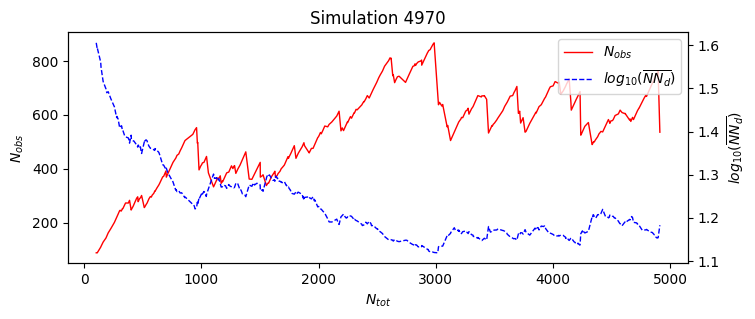

slope                           2.181560
effective_radius_multiplier     1.627329
r_stat_multiplier              14.682956
min_rim_percentage              0.526957
Name: 59337, dtype: float64


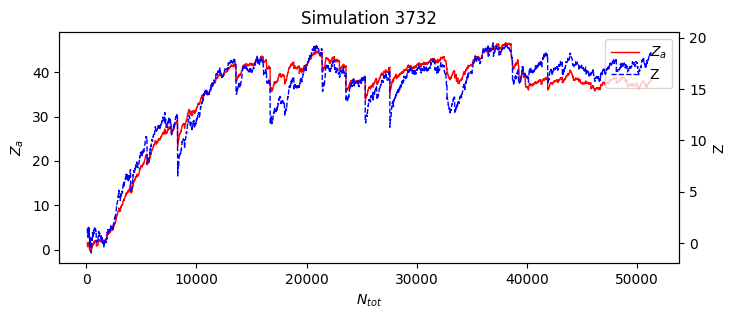

slope                           2.181560
effective_radius_multiplier     1.627329
r_stat_multiplier              14.682956
min_rim_percentage              0.526957
Name: 59337, dtype: float64


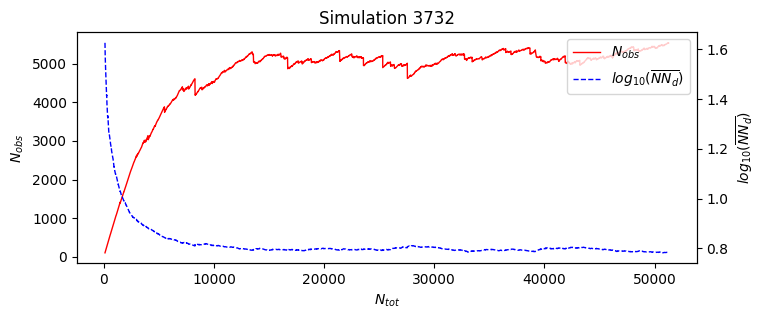

slope                           1.667920
effective_radius_multiplier     1.644673
r_stat_multiplier              14.130094
min_rim_percentage              0.569435
Name: 79869, dtype: float64


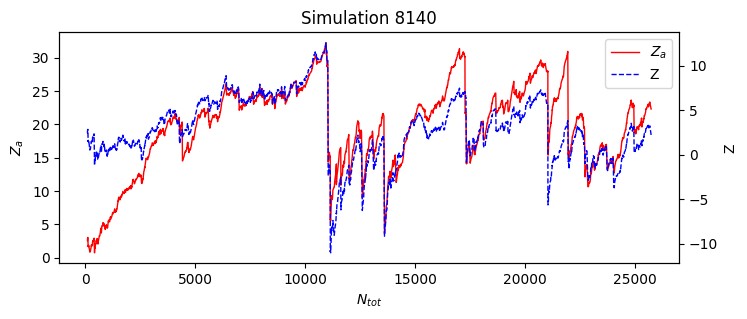

slope                           1.667920
effective_radius_multiplier     1.644673
r_stat_multiplier              14.130094
min_rim_percentage              0.569435
Name: 79869, dtype: float64


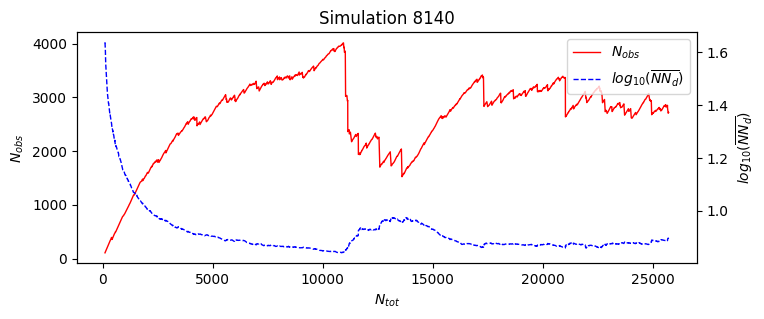

slope                          2.198918
effective_radius_multiplier    1.236233
r_stat_multiplier              7.856119
min_rim_percentage             0.660093
Name: 18158, dtype: float64


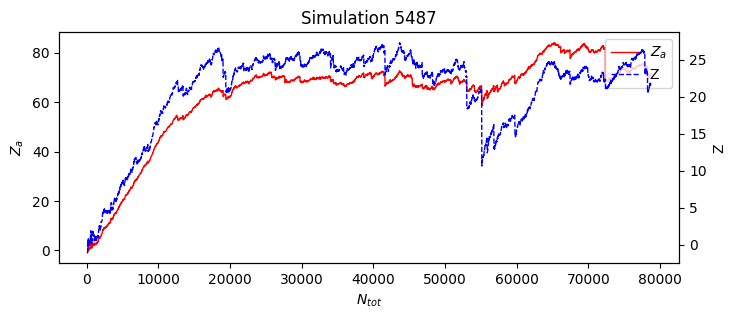

slope                          2.198918
effective_radius_multiplier    1.236233
r_stat_multiplier              7.856119
min_rim_percentage             0.660093
Name: 18158, dtype: float64


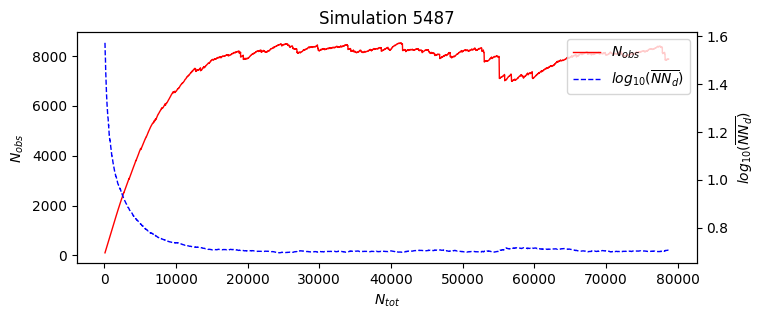

slope                           1.442828
effective_radius_multiplier     1.472294
r_stat_multiplier              12.832767
min_rim_percentage              0.671753
Name: 86598, dtype: float64


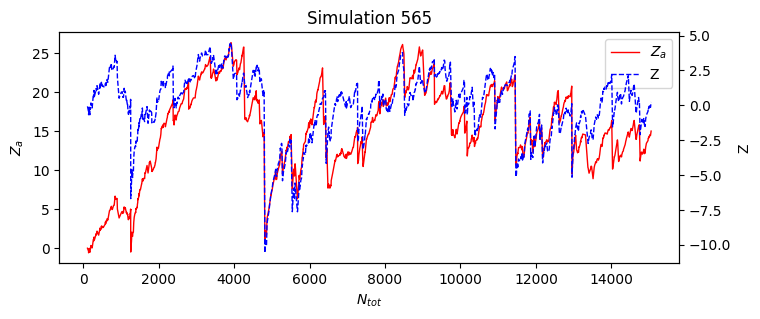

slope                           1.442828
effective_radius_multiplier     1.472294
r_stat_multiplier              12.832767
min_rim_percentage              0.671753
Name: 86598, dtype: float64


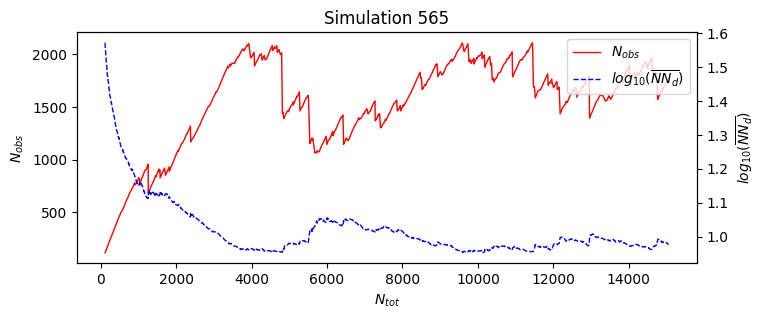

slope                          2.442058
effective_radius_multiplier    1.469991
r_stat_multiplier              8.950921
min_rim_percentage             0.542720
Name: 53270, dtype: float64


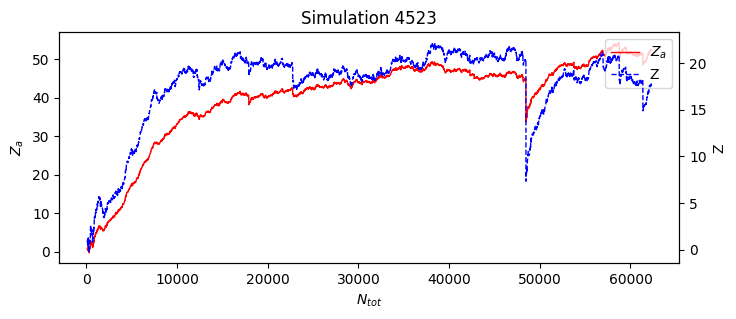

slope                          2.442058
effective_radius_multiplier    1.469991
r_stat_multiplier              8.950921
min_rim_percentage             0.542720
Name: 53270, dtype: float64


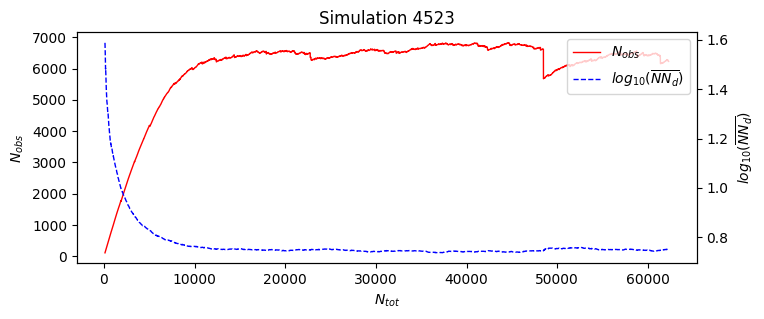

slope                           2.942771
effective_radius_multiplier     1.839663
r_stat_multiplier              11.925014
min_rim_percentage              0.456443
Name: 82467, dtype: float64


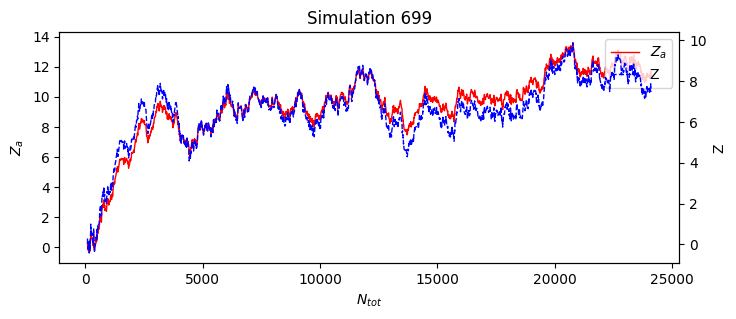

slope                           2.942771
effective_radius_multiplier     1.839663
r_stat_multiplier              11.925014
min_rim_percentage              0.456443
Name: 82467, dtype: float64


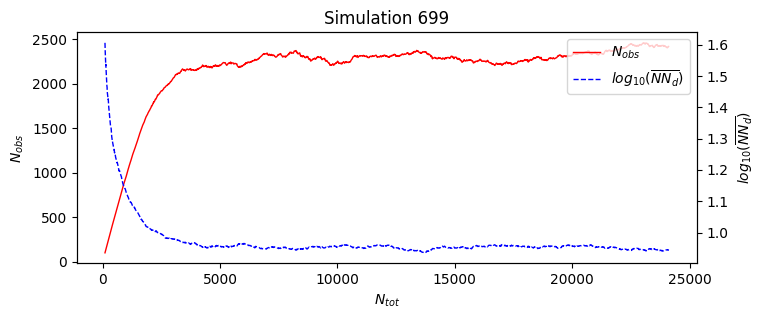

slope                          2.243237
effective_radius_multiplier    1.794941
r_stat_multiplier              8.905309
min_rim_percentage             0.259009
Name: 10010, dtype: float64


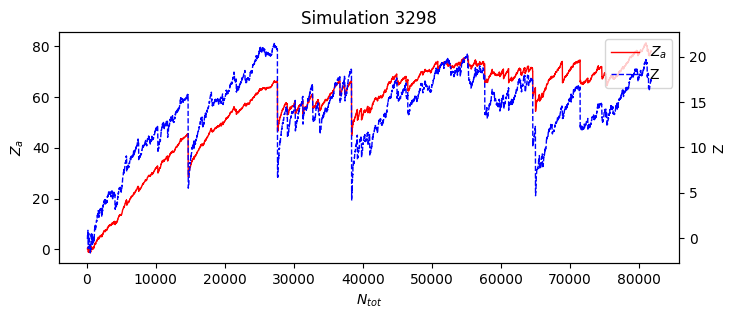

slope                          2.243237
effective_radius_multiplier    1.794941
r_stat_multiplier              8.905309
min_rim_percentage             0.259009
Name: 10010, dtype: float64


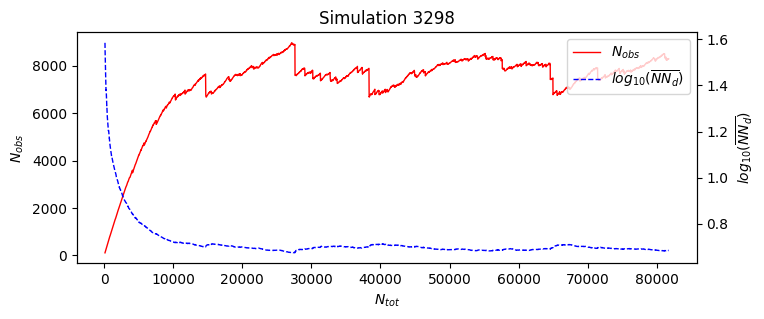

slope                          2.608236
effective_radius_multiplier    1.603214
r_stat_multiplier              9.416797
min_rim_percentage             0.651872
Name: 73054, dtype: float64


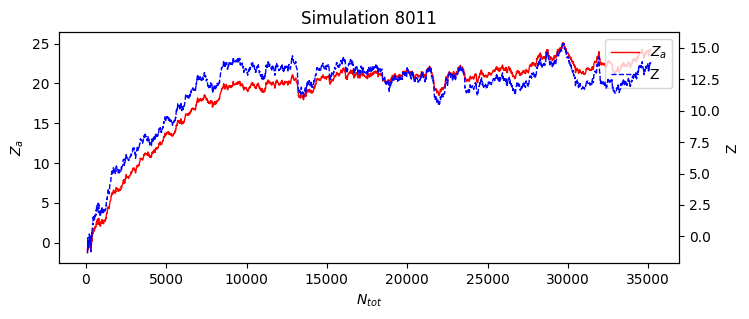

slope                          2.608236
effective_radius_multiplier    1.603214
r_stat_multiplier              9.416797
min_rim_percentage             0.651872
Name: 73054, dtype: float64


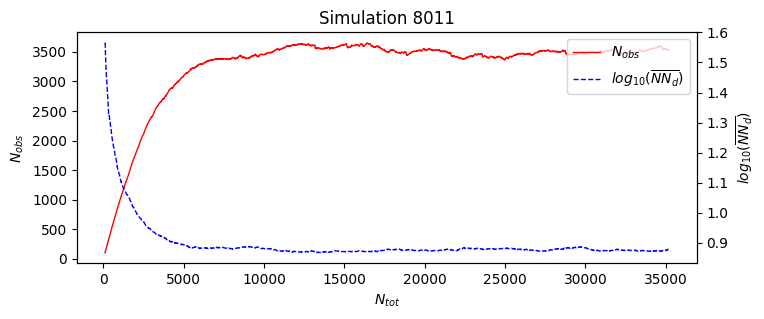

In [37]:
for sim_id in sim_ids:
    dual_plot_for_simulation(sim_id, "za", "$Z_a$", "z", "Z", df_s)
    dual_plot_for_simulation(sim_id, "n_craters_in_study_region", "$N_{obs}$", "log_mean_c2c_nn_dist", "$log_{10}(\overline{NN_d})$", df_s)
    # plot_log_N_and_log_NNd_for_simulation(sim_id, df_s)
    # plot_AD_and_Za_for_simulation(sim_id, df_s)|

In [9]:
# Randomly arrange the points
# Ordering affects which points in the subsequent plots are "on top" of others
df["rnd"] = np.random.rand(df.shape[0])
df = df.sort_values("rnd")

In [10]:
df.columns

Index(['slope', 'min_rim_percentage', 'effective_radius_multiplier',
       'r_stat_multiplier', 'crater_id', 'n_craters_added_in_study_region',
       'n_craters_in_study_region', 'areal_density', 'areal_density_overlap_2',
       'areal_density_overlap_3',
       'center_to_center_nearest_neighbor_distance_mean',
       'center_to_center_nearest_neighbor_distance_stdev',
       'center_to_center_nearest_neighbor_distance_min',
       'center_to_center_nearest_neighbor_distance_max', 'radius_mean',
       'radius_stdev', 'z', 'za', 'simulation_id', 'log_mean_c2c_nn_dist',
       'log_n_craters_in_study_region', 'log_n_craters_added_in_study_region',
       'information_remaining', 'rnd'],
      dtype='object')

In [11]:
df["log_za"] = np.log10(df.za)
fig = px.scatter_3d(
    df,
    x="log_n_craters_in_study_region",
    y="log_n_craters_added_in_study_region",
    z="slope",
    color="log_n_craters_in_study_region",
    hover_data=["simulation_id", "slope", "n_craters_added_in_study_region", "areal_density", "n_craters_in_study_region"],
    size_max=1,
    width=1000,
    height=500
)
fig.update_layout(
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
    xaxis_title=dict(
        text="za",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":1})
fig.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log10



In [12]:
# Trying a range selector
to_show = df.copy()
to_show["slope_selector"] = ((to_show.slope - 1) * 10).astype("int") / 10 + 1
to_show = to_show.sort_values("slope_selector")
to_show["index"] = range(to_show.shape[0])

range_x = [to_show.log_n_craters_in_study_region.min(), to_show.log_n_craters_in_study_region.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]

fig = px.scatter(
    to_show,
    x="log_n_craters_in_study_region",
    y="log_n_craters_added_in_study_region",
    color="log_n_craters_in_study_region",
    hover_data=["slope", "n_craters_added_in_study_region"],
    size_max=1,
    animation_frame="slope_selector",
    animation_group="index",
    range_x=range_x,
    range_y=range_y,
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(N_{obs})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [52]:
fig = px.scatter(
    df,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_in_study_region",
    color="slope",
    hover_data=["simulation_id", "slope", "n_craters_added_in_study_region", "areal_density", "n_craters_in_study_region"],
    size_max=1,
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{obs})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [37]:
fig = px.scatter_3d(
    df,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_in_study_region",
    z="slope",
    color="slope",
    hover_data=["simulation_id", "slope", "n_craters_added_in_study_region", "areal_density", "n_craters_in_study_region"],
    size_max=1,
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{obs})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [63]:
fig = px.scatter(
    df,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_added_in_study_region",
    color="slope",
    hover_data=["simulation_id", "slope", "n_craters_added_in_study_region", "areal_density", "n_craters_in_study_region"],
    size_max=1,
    width=1600,
    height=600,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(\overline{NN_d}})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [36]:
# Trying a range selector
to_show = df.copy()
to_show["slope_selector"] = ((to_show.slope - 1) * 10).astype("int") / 10 + 1
to_show = to_show.sort_values("slope_selector")
to_show["index"] = range(to_show.shape[0])

range_x = [to_show.log_mean_c2c_nn_dist.min(), to_show.log_mean_c2c_nn_dist.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]

fig = px.scatter(
    to_show,
    x="log_mean_c2c_nn_dist",
    y="log_n_craters_added_in_study_region",
    color="log_n_craters_in_study_region",
    hover_data=["slope", "n_craters_added_in_study_region"],
    size_max=1,
    animation_frame="slope_selector",
    animation_group="index",
    range_x=range_x,
    range_y=range_y,
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(N_{obs}})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [22]:
fig = px.scatter(
    df,
    x="log_n_craters_in_study_region",
    y="log_n_craters_added_in_study_region",
    color="slope",
    hover_data=["simulation_id", "slope", "n_craters_added_in_study_region", "areal_density", "n_craters_in_study_region"],
    size_max=1,
    width=1600,
    height=600,
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(N_{obs}})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log_{10}(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

In [34]:
# Comparing N_tot to N_obs
# Trying a range selector
to_show = df.copy()
to_show["slope_selector"] = ((to_show.slope - 1) * 10).astype("int") / 10 + 1
to_show = to_show.sort_values("slope_selector")
to_show["index"] = range(to_show.shape[0])

range_x = [to_show.log_n_craters_in_study_region.min(), to_show.log_n_craters_in_study_region.max()]
range_y = [to_show.log_n_craters_added_in_study_region.min(), to_show.log_n_craters_added_in_study_region.max()]

fig = px.scatter(
    to_show,
    x="log_n_craters_in_study_region",
    y="log_n_craters_added_in_study_region",
    color="log_mean_c2c_nn_dist",
    hover_data=["slope", "n_craters_added_in_study_region"],
    size_max=1,
    animation_frame="slope_selector",
    animation_group="index",
    range_x=range_x,
    range_y=range_y,
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title=dict(
        text="$log_{10}(N_{obs}})$",
        font=dict(size=18)
    ),
    yaxis_title=dict(
        text="$log(N_{tot})$",
        font=dict(size=18)
    ),
)
fig.update_traces(marker={"size":3})
fig.show()

## Plotting single simulations

In [ ]:
df = data.where(
    (F.col("n_craters_added_in_study_region") > F.lit(25))
    & (data.simulation_id == 4935)
).cache()

n_pts = 10000
n_obs = df.count()

if n_obs > n_pts:
    sample_fraction = n_pts / n_obs
    df = df.sample(sample_fraction)

pandas_df = df.toPandas()
pandas_df["log_n_craters_in_study_region"] = np.log10(pandas_df.n_craters_in_study_region)
pandas_df = pandas_df.sort_values("log_n_craters_in_study_region")

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(
    # np.log10(pandas_df.n_craters_added_in_study_region),
    np.log10(pandas_df.log_n_craters_in_study_region),
    pandas_df.log_mean_c2c_nn_dist,    
)
plt.title("Single Simulation, b=3")
plt.xlabel("$log_{10}(N_{tot})$", size=14)
plt.ylabel("$log_{10}(\overline{NN_d})$", size=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(
    np.log10(pandas_df.n_craters_added_in_study_region),
    np.log10(pandas_df.n_craters_in_study_region),
)
plt.title("Single Simulation, b=3")
plt.xlabel("$log_{10}(N_{tot})$", size=14)
plt.ylabel("$log_{10}(N_obs)$", size=14)
plt.show()